## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_vertical_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\coco\\indoor\\wavelet\\vertical\\green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


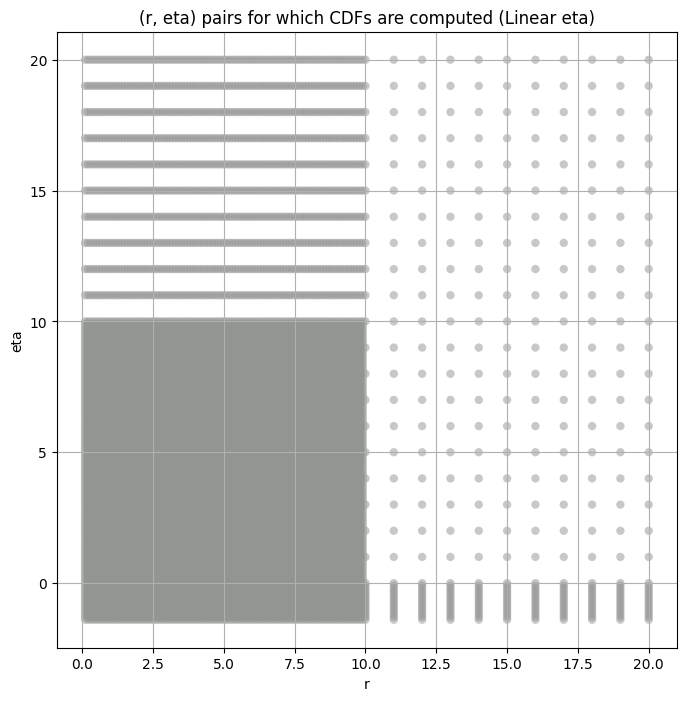

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4718.657000  4299.349000  5150.550300  -0.054184   -0.312345   
3      1216.926300  1148.097900  1286.854100   1.147205    0.911357   
4       264.944550   250.008090   280.323400   2.901463    2.384805   
5        52.718760    49.047108    56.922474   6.263205    4.254791   
6         9.496005     8.706043    10.395535   9.788740    6.967327   
7         1.674932     1.508111     1.862111  14.589886   10.600601   
8         0.319952     0.279325     0.374371  29.505913   16.159815   
9         0.070265     0.059721     0.085715  46.324802   21.752464   

       kurt_upper  total_samples  
layer                             
2        0.254048           1604  
3        1.392681           6416  
4        3.499158          25664  
5       16.023062         102656  
6       22.610666         410624  
7       28.399412        1642496  
8       97.240685        6569984  
9      167.660170       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      4718.657000    4718.657227     3952.960693     3428.063721   
3      1216.926300    1216.926270     1112.503784     1040.837402   
4       264.944550     264.944550      252.954987      244.723892   
5        52.718760      52.718761       51.331055       50.512314   
6         9.496005       9.496005        9.191224        9.000786   
7         1.674932       1.674932        1.604153        1.560504   
8         0.319952       0.319952        0.299252        0.288096   
9         0.070265       0.070265        0.064260        0.061181   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         3025.269531      2687.656982      2144.858887      1718.110718   
3          980.459290       927.277649       838.595459       764.237854   
4          237.882385       231.782288       221.122253       211.928360   
5           49.824306        49.209888        48.119991        47.155079   
6            8.840061         8.695685         8.438622         8.211010   
7            1.523452         1.490454         1.432664         1.382283   
8            0.278797         0.270688         0.256764         0.244906   
9            0.058691         0.056556         0.052987         0.050039   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1370.848755      1073.028198       826.254578       326.304260  
3           700.754456       645.801819       597.966736       482.256378  
4           203.777405       196.402405       189.611542       172.177261  
5            46.271584        45.457996        44.691013        42.602451  
6             8.003604         7.813096         7.635841         7.166869  
7             1.337258         1.296453         1.258974         1.161281  
8             0.234518         0.225238         0.216850         0.195685  
9             0.047514         0.045305         0.043340         0.038493

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.015001414905372323 4718.657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03458455980855313 3952.9607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0515217036501459 3428.0637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06602554589056946 3025.2695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0793124799894889 2687.657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10496661027630236 2144.859


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12814214617054048 1718.1107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1487730860149838 1370.8488


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17242758734426725 1073.0282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20057431706208223 826.2546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.27905714154994254 326.30426
Number of samples: 1604, Without approximation : 1604


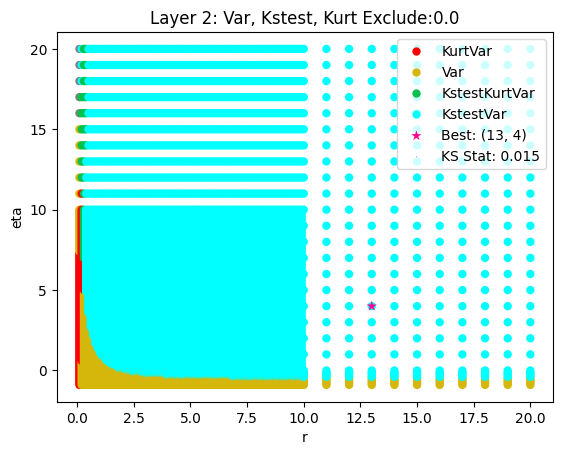

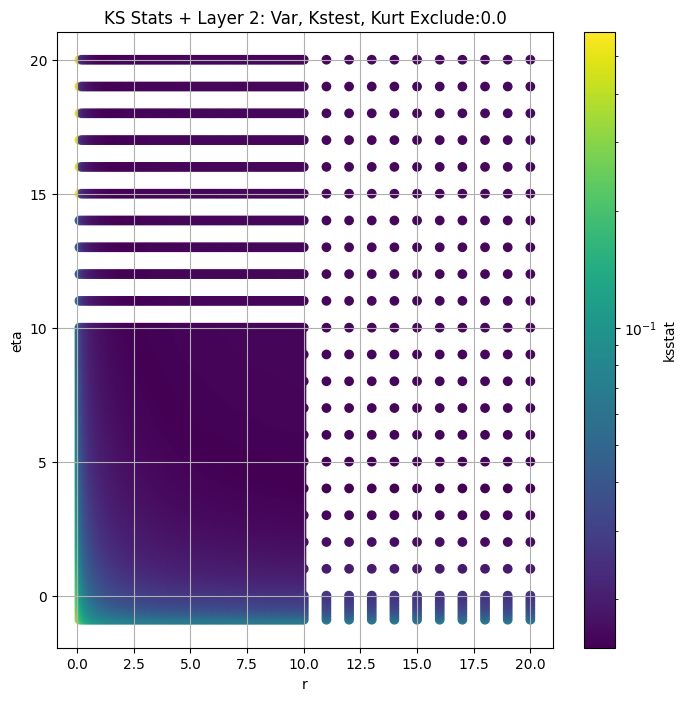

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.008347290975653787 1216.9263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.008791469431059427 1112.5038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01337924435491105 1040.8374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.017668584776851418 980.4593


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.022066672583020648 927.27765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.030564502938754 838.59546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.038496621074124854 764.23785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04620804056518974 700.75446


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.053273546251319304 645.8018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06006649032632827 597.96674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08245441062720815 482.25638
Number of samples: 6416, Without approximation : 6416


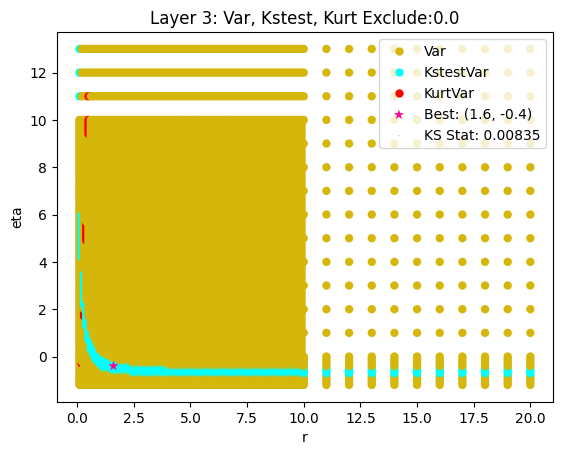

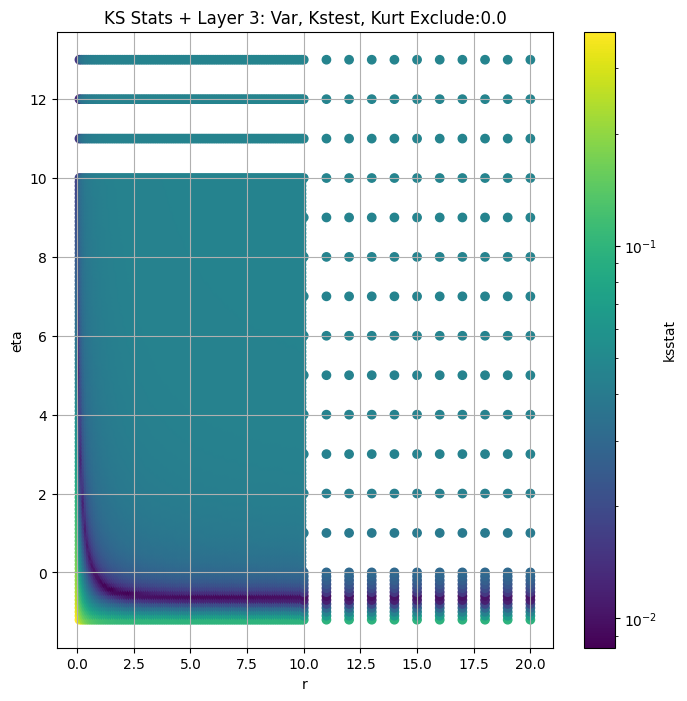

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.003263511006493802 264.94455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0038607863224600636 252.95499


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.0042188059853600635 244.72389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0054196071957647585 237.88239


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006655600709395464 231.78229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.00923631088124495 221.12225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.011621104402852245 211.92836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.014155660755704957 203.7774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01658196192846373 196.4024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.018858891603766192 189.61154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.025526767296631503 172.17726
Number of samples: 25664, Without approximation : 25664


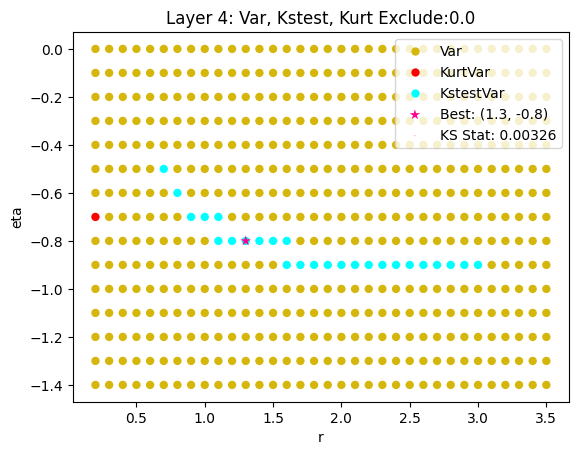

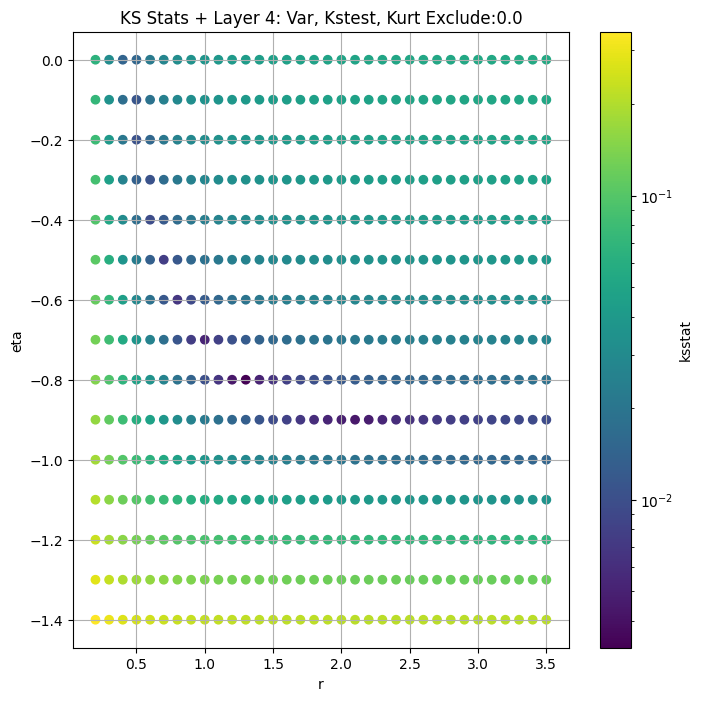

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.007019390356620414 52.71876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.005832560063494419 51.331055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.006124247603999766 50.512314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0064502318033867745 49.824306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.007155484105056842 49.20989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006915063137870159 48.11999


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.008037679044436197 47.15508


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008137596522288848 46.271584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008980005578261951 45.457996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.009311070679649758 44.691013


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.010929224930000925 42.60245
Number of samples: 100000, Without approximation : 102656


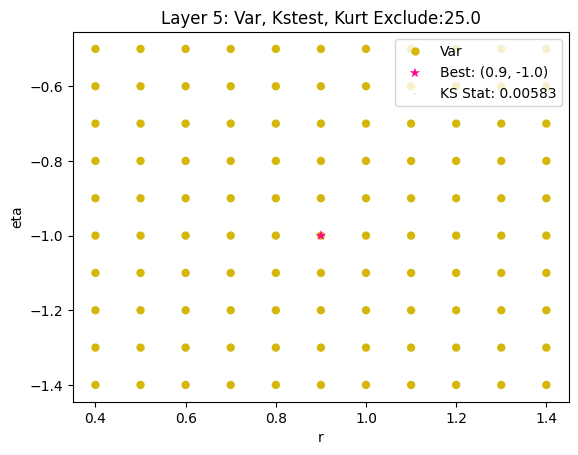

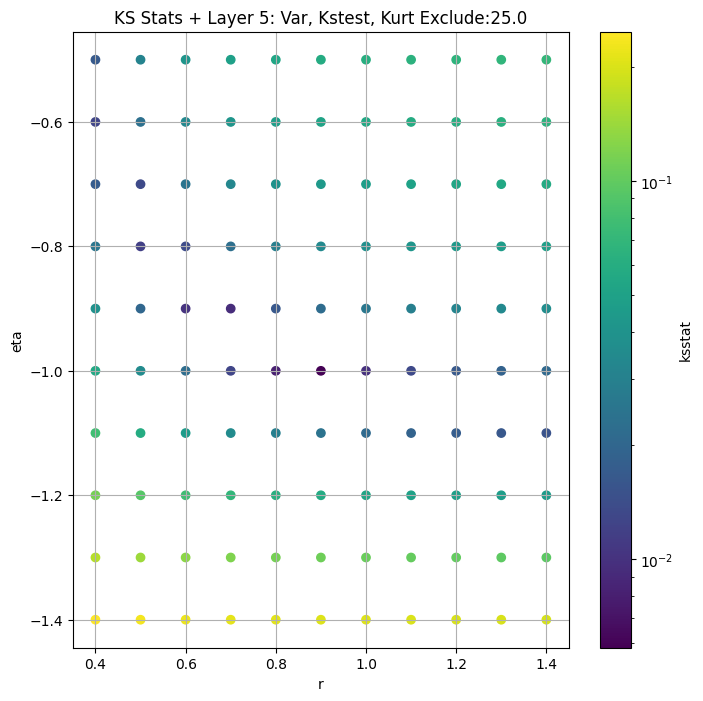

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.008983261338147919 9.496005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.008701377703568047 9.191224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.008604080035634176 9.000786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.008658876619383402 8.840061


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009407046524565685 8.695685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.010784018694483644 8.438622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.011531096231582105 8.21101


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.011922042827852808 8.003604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.011657929831894231 7.813096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.010643469549630802 7.635841


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0114753698432144 7.1668687
Number of samples: 100000, Without approximation : 410624


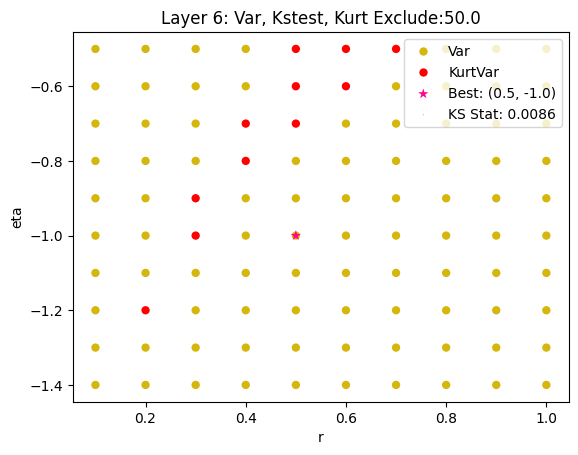

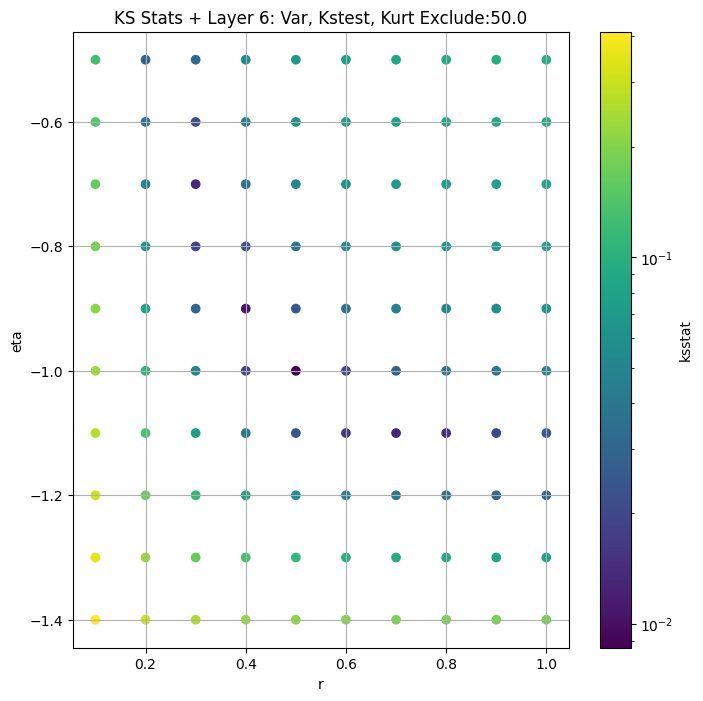

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.018364727385575152 1.6749315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.017863069787392993 1.6041532


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.0175425409295622 1.5605042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.017262283013613433 1.523452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.017006188524471888 1.4904542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.01654457826097311 1.4326638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.016121628203705163 1.3822833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.016136598572700556 1.3372575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.017258647461606436 1.2964531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.018328279717688467 1.2589744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.017355517444663238 1.1612812
Number of samples: 100000, Without approximation : 1642496


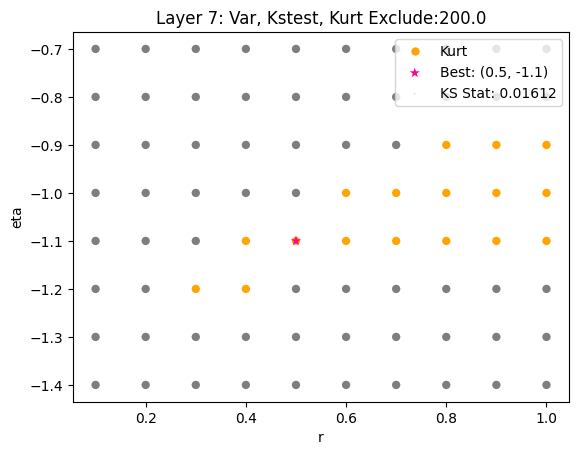

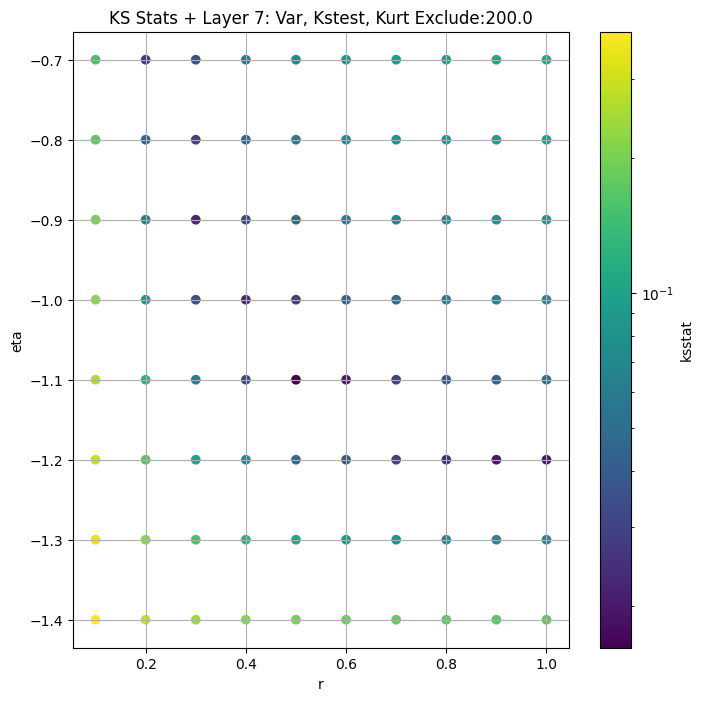

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.007301826377736381 0.3199518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.005784655260920424 0.2992521


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006981624718001012 0.288096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008064396162555387 0.2787968


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.009090631801129123 0.2706882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008311805387037907 0.25676417


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009801638955733605 0.24490638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007986822621381728 0.23451802


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009106073155484617 0.2252376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010249205673349193 0.21685046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010541188025649961 0.19568495
Number of samples: 100000, Without approximation : 6569984


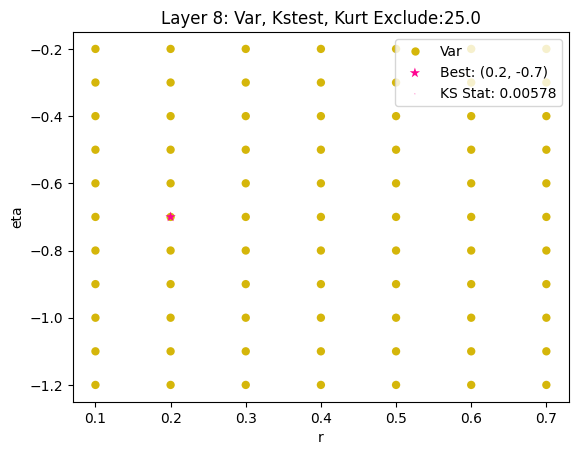

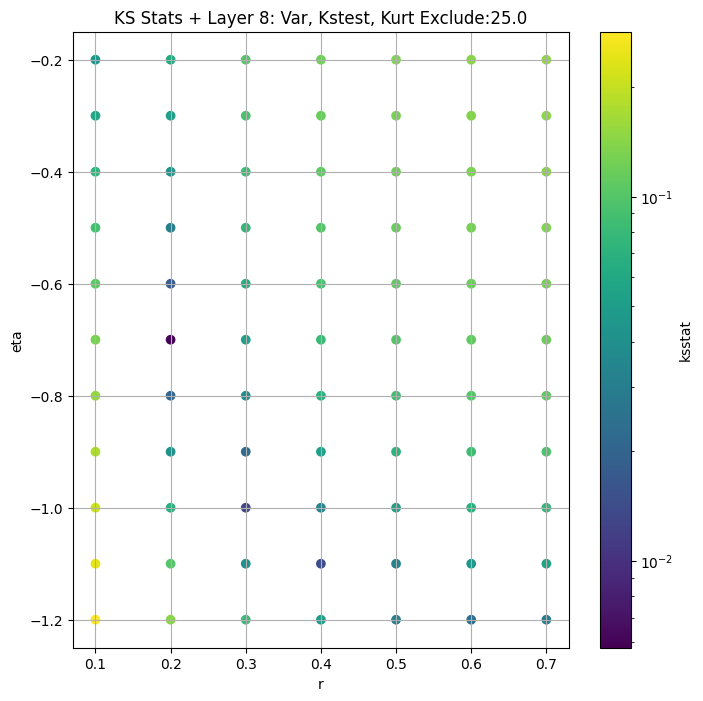

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.012399040739677014 0.07026459


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.013683224701407787 0.064259894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.013781887408229387 0.061181102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.012847974242707241 0.058691066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.014739928824353182 0.05655608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.014389571457169903 0.052986946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.014513139192137814 0.050039113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.015199445095545439 0.047513705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.015925834189689292 0.04530469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.016667482366938935 0.043339875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.015477045821750746 0.038492724
Number of samples: 100000, Without approximation : 26279936


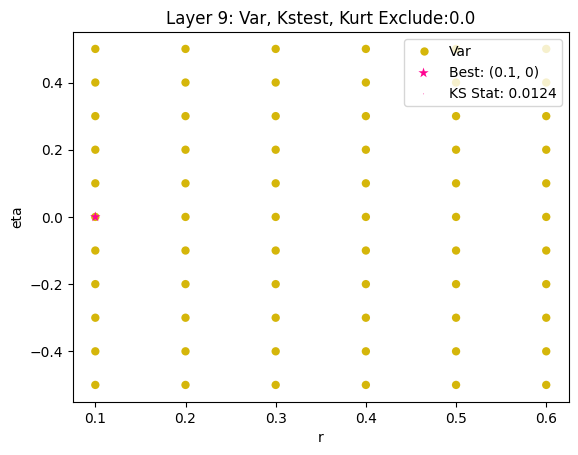

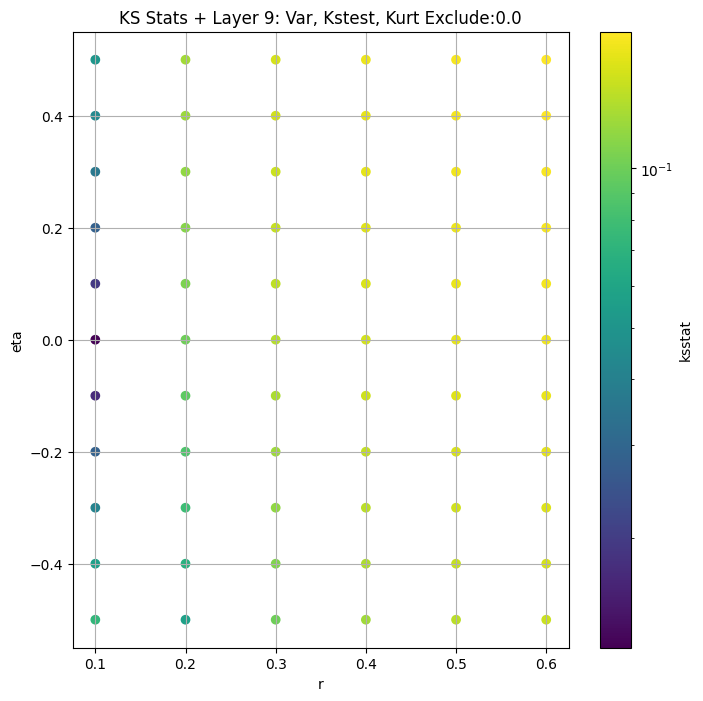

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4718.657000  4299.349000  5150.550300  -0.054184   -0.312345   
3      1216.926300  1148.097900  1286.854100   1.147205    0.911357   
4       264.944550   250.008090   280.323400   2.901463    2.384805   
5        52.718760    49.047108    56.922474   6.263205    4.254791   
6         9.496005     8.706043    10.395535   9.788740    6.967327   
7         1.674932     1.508111     1.862111  14.589886   10.600601   
8         0.319952     0.279325     0.374371  29.505913   16.159815   
9         0.070265     0.059721     0.085715  46.324802   21.752464   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.254048           1604             0.015001       13.0          4.0   
3        1.392681           6416             0.008347        1.6         -0.4   
4        3.499158          25664             0.003264        1.3         -0.8   
5       16.023062         102656             0.005833        0.9         -1.0   
6       22.610666         410624             0.008604        0.5         -1.0   
7       28.399412        1642496             0.016122        0.5         -1.1   
8       97.240685        6569984             0.005785        0.2         -0.7   
9      167.660170       26279936             0.012399        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       5.576727e+03                     0.0         4718.657000   
3       1.791173e+03                     0.0         1216.926300   
4       4.875084e+02                     0.0          264.944550   
5       9.101842e+01                    25.0           51.331055   
6       4.500393e+00                    50.0            9.000786   
7       9.599190e-01                   200.0            1.382283   
8       4.453156e-05                    25.0            0.299252   
9       9.872774e-15                     0.0            0.070265   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08057139087328953, var: 2687.656982421875


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06710379586035219, var: 3025.26953125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.052822142968380656, var: 3428.063720703125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.03611172811728616, var: 3952.960693359375


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.015001414905372323, var: 4718.6572265625
Number of samples: 1604, Without approximation : 1604


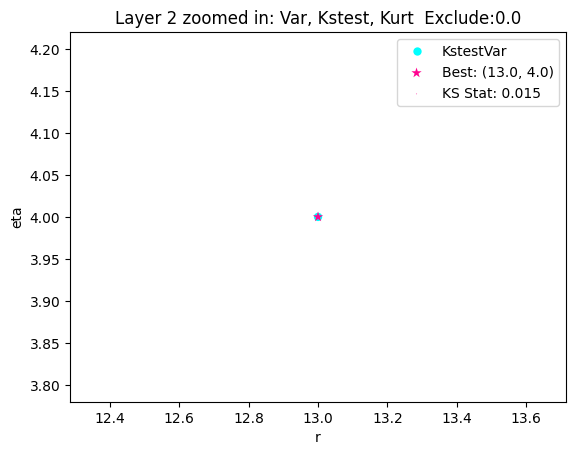

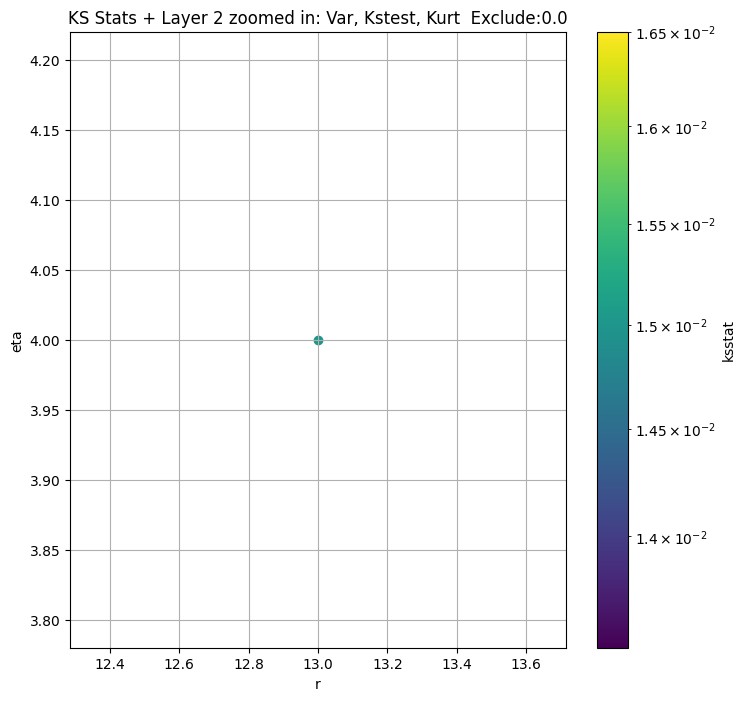

Layer 3


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.025730596820114138, var: 927.2776489257812


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02000894520505174, var: 980.4592895507812


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01470799251393766, var: 1040.83740234375


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.010445406377936228, var: 1112.5037841796875


  0%|          | 0/1539 [00:00<?, ?it/s]

Finding Minimum after computing 1539 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.00806462130200869, var: 1216.92626953125
Number of samples: 6416, Without approximation : 6416


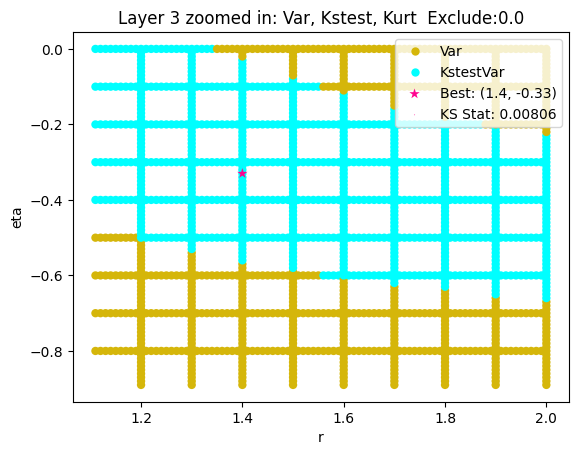

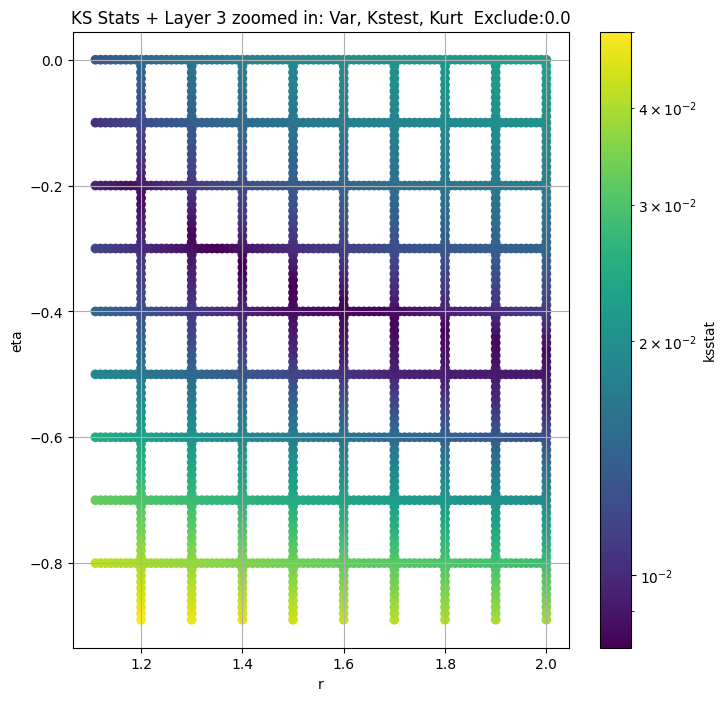

Layer 4


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.008656439092298962, var: 231.78228759765625


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.007026152746252623, var: 237.88238525390625


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005419120367484168, var: 244.72389221191406


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.0036986857765927347, var: 252.95498657226562


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0023656889989416285, var: 264.9445495605469
Number of samples: 25664, Without approximation : 25664


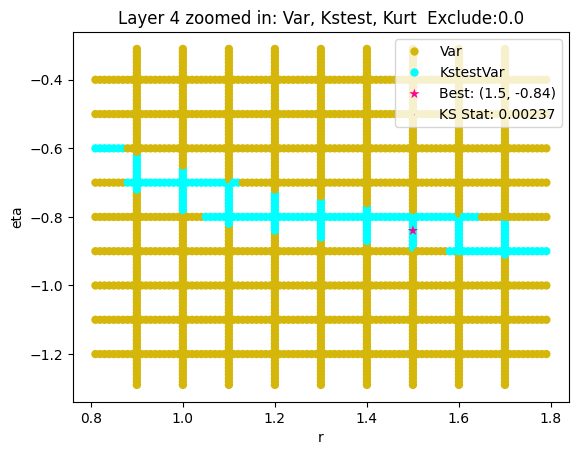

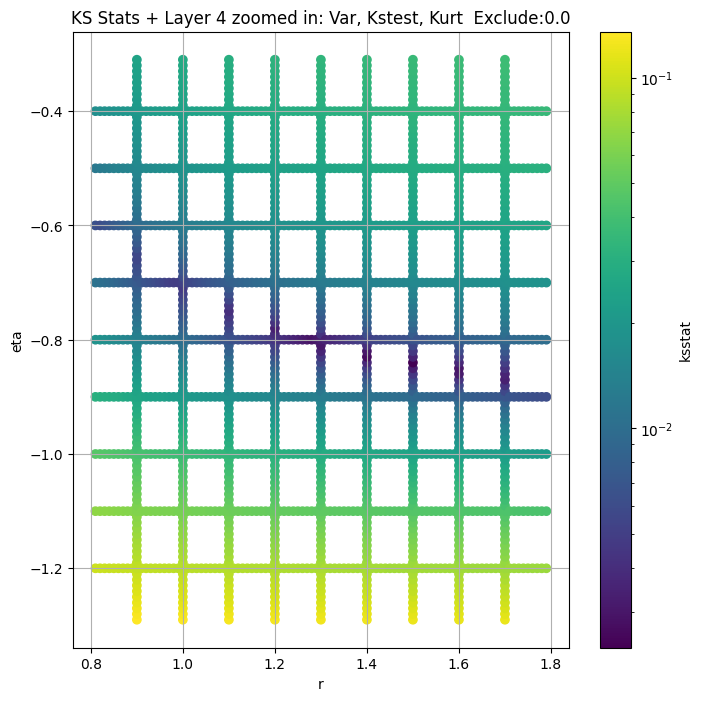

Layer 5


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.006465284146605299, var: 48.6479606628418


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.006076709306345407, var: 49.20988845825195


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.005767602669084715, var: 49.82430648803711


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.005751154089541521, var: 50.51231384277344


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.005832560063494419, var: 51.3310546875


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.005150786425767051, var: 52.7187614440918
Number of samples: 100000, Without approximation : 102656


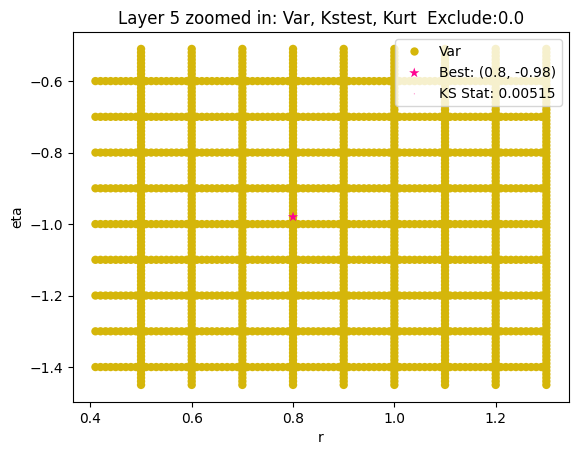

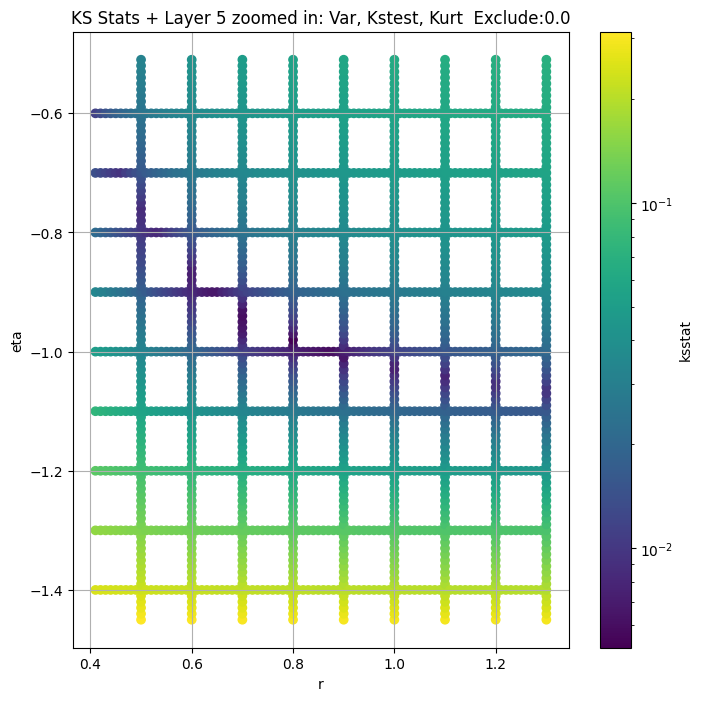

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.008122271820440813, var: 8.43862247467041


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.008116531060557819, var: 8.562588691711426


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.008816092546097554, var: 8.695685386657715


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.008658876619383402, var: 8.84006118774414


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.008196717038744597, var: 9.000785827636719


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.008175586993122763, var: 9.191224098205566


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.008222891424754297, var: 9.496005058288574
Number of samples: 100000, Without approximation : 410624


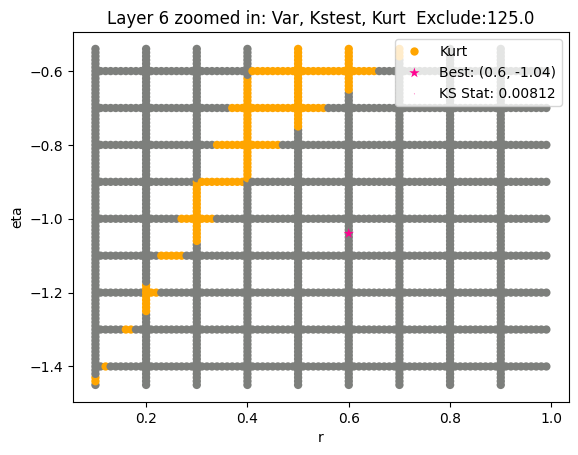

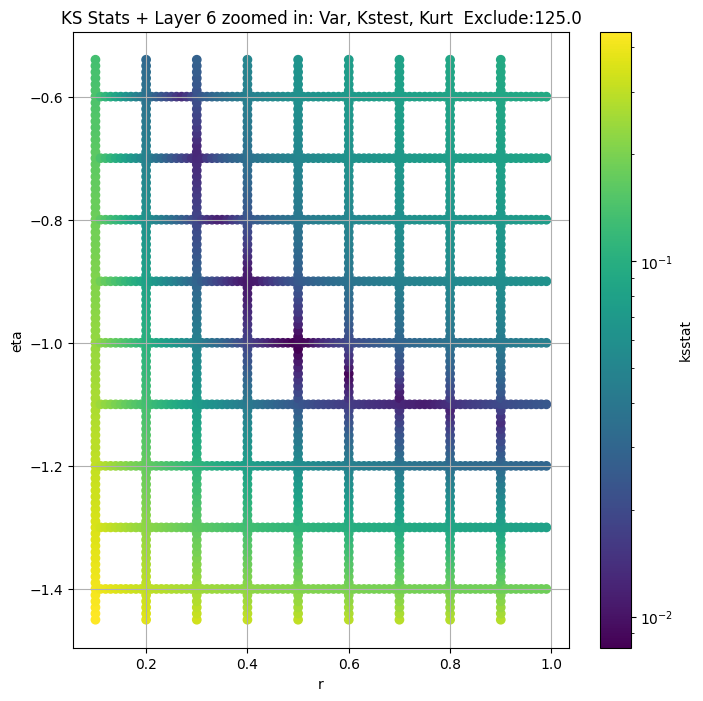

Layer 7


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 100 = 300, ksstat: 0.013873854699347932, var: 1.2964531183242798


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 75 = 275, ksstat: 0.014112431339409676, var: 1.316395878791809


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 50 = 250, ksstat: 0.014980785303092381, var: 1.3372575044631958


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 25 = 225, ksstat: 0.015149260242901086, var: 1.3591806888580322


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + 0 = 200, ksstat: 0.014596131928784395, var: 1.382283329963684


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -25 = 175, ksstat: 0.015163238276578617, var: 1.4067193269729614


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -50 = 150, ksstat: 0.014538950584112142, var: 1.4326637983322144


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -75 = 125, ksstat: 0.0141842142585058, var: 1.4604624509811401


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 200.0 + -100 = 100, ksstat: 0.014423013183624378, var: 1.4904541969299316
Number of samples: 100000, Without approximation : 1642496


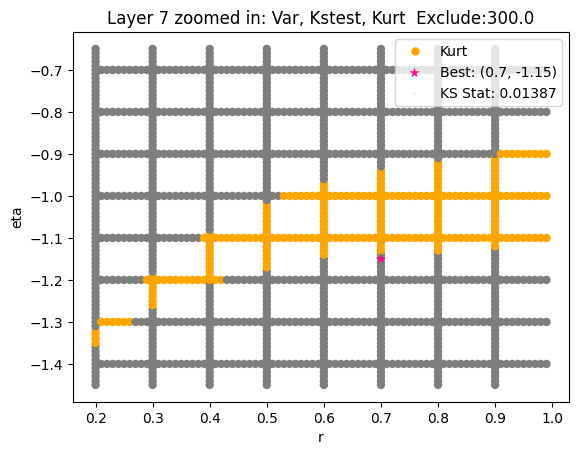

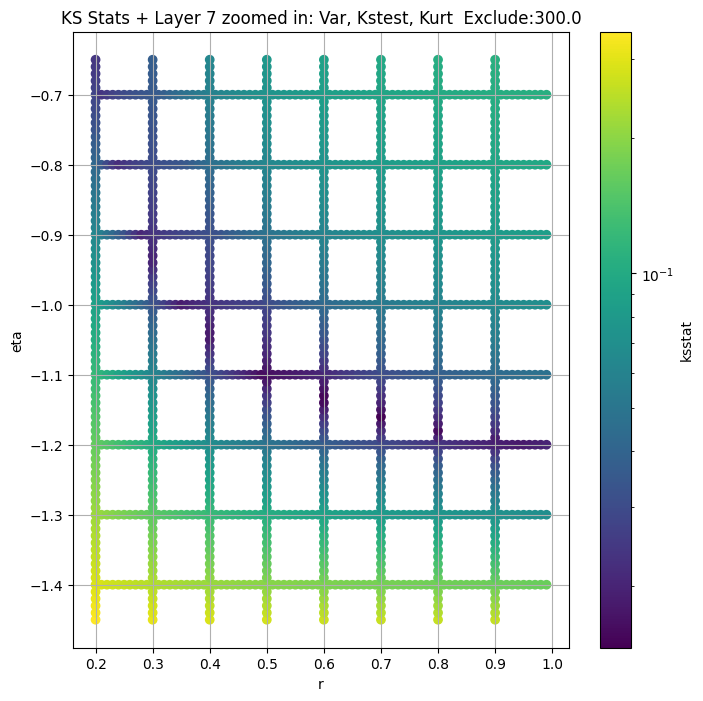

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.0066120070861408475, var: 0.26341187953948975


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.006351927086768239, var: 0.2706882059574127


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.005799334981976323, var: 0.2787967920303345


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.005535030296558663, var: 0.28809601068496704


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.005543081042878706, var: 0.29925209283828735


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.004410478756169817, var: 0.3199518024921417
Number of samples: 100000, Without approximation : 6569984


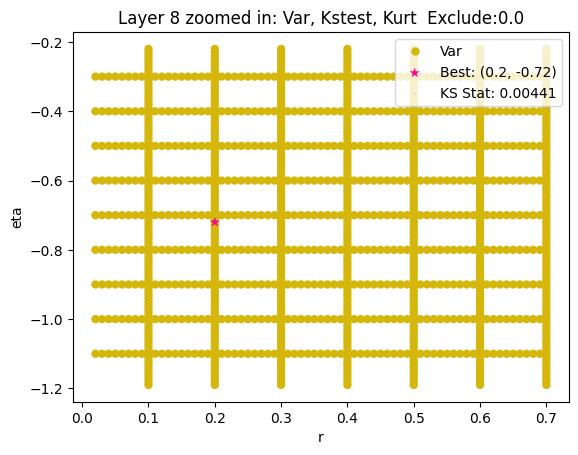

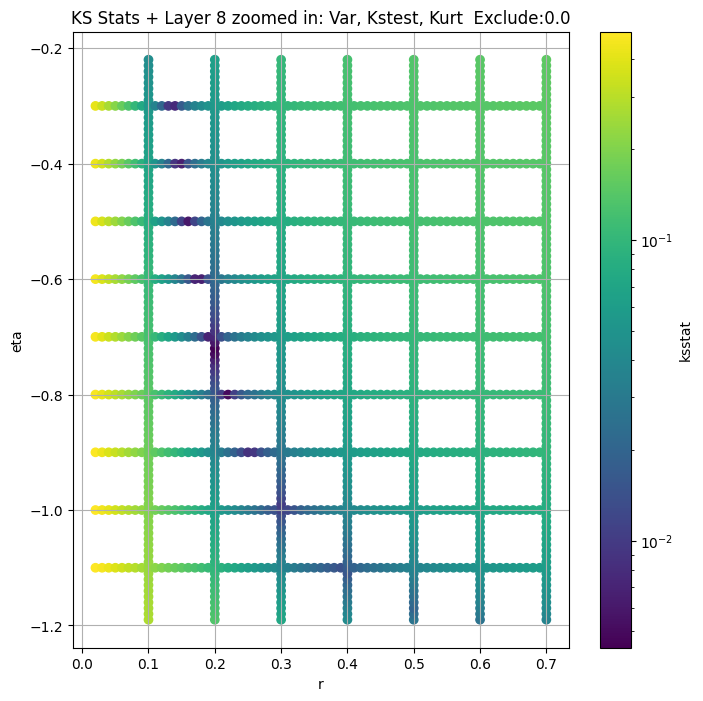

Layer 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.01301725054658831, var: 0.05655607953667641


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.012553111085784108, var: 0.05869106575846672


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.012141164679444483, var: 0.06118110194802284


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.012147417630475832, var: 0.06425989419221878


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.011994661744983093, var: 0.07026459276676178
Number of samples: 100000, Without approximation : 26279936


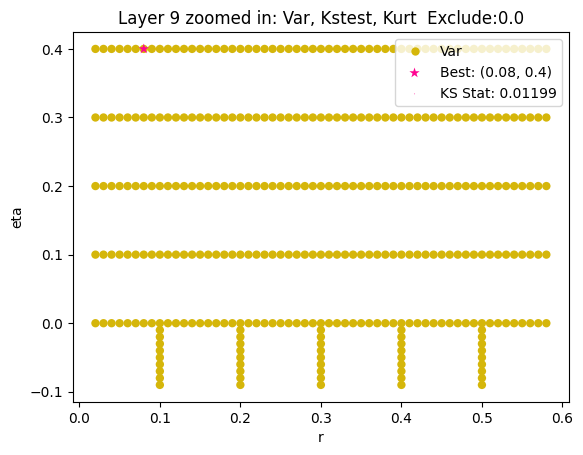

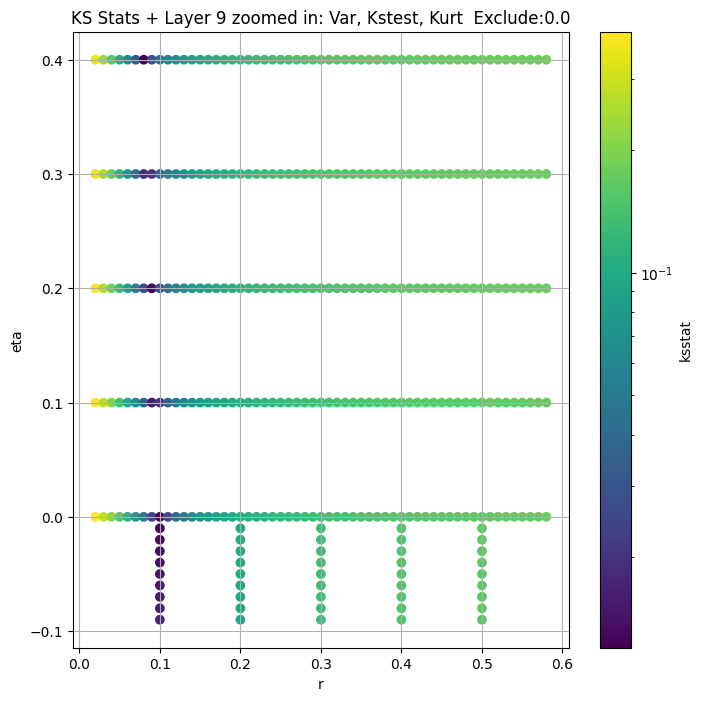

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4718.657000  4299.349000  5150.550300  -0.054184   -0.312345   
3      1216.926300  1148.097900  1286.854100   1.147205    0.911357   
4       264.944550   250.008090   280.323400   2.901463    2.384805   
5        52.718760    49.047108    56.922474   6.263205    4.254791   
6         9.496005     8.706043    10.395535   9.788740    6.967327   
7         1.674932     1.508111     1.862111  14.589886   10.600601   
8         0.319952     0.279325     0.374371  29.505913   16.159815   
9         0.070265     0.059721     0.085715  46.324802   21.752464   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.254048           1604             0.015001       13.0          4.0   
3        1.392681           6416             0.008347        1.6         -0.4   
4        3.499158          25664             0.003264        1.3         -0.8   
5       16.023062         102656             0.005833        0.9         -1.0   
6       22.610666         410624             0.008604        0.5         -1.0   
7       28.399412        1642496             0.016122        0.5         -1.1   
8       97.240685        6569984             0.005785        0.2         -0.7   
9      167.660170       26279936             0.012399        0.1          0.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       5.576727e+03                     0.0         4718.657000   
3       1.791173e+03                     0.0         1216.926270   
4       4.875084e+02                     0.0          264.944550   
5       9.101842e+01                    25.0           52.718761   
6       4.500393e+00                    50.0            8.562589   
7       9.599190e-01                   200.0            1.296453   
8       4.453156e-05                    25.0            0.319952   
9       9.872774e-15                     0.0            0.070265   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.015001   13.00      4.00   
3                     0.016929          0.008065    1.40     -0.33   
4                     0.008471          0.002366    1.50     -0.84   
5                     0.004237          0.005151    0.80     -0.98   
6                     0.002119          0.008117    0.60     -1.04   
7                     0.001060          0.013874    0.70     -1.15   
8                     0.000530          0.004410    0.20     -0.72   
9                     0.000265          0.011995    0.08      0.40   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      5.576727e+03                  0.0         8119  
3      1.542128e+03                  0.0        27405  
4      5.622286e+02                  0.0       328869  
5      7.590692e+01                  0.0        73081  
6      8.117543e+00                125.0        28872  
7      2.364403e+00                300.0         9624  
8      5.205898e-05                  0.0        97443  
9      3.272356e-20                  0.0        12832

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

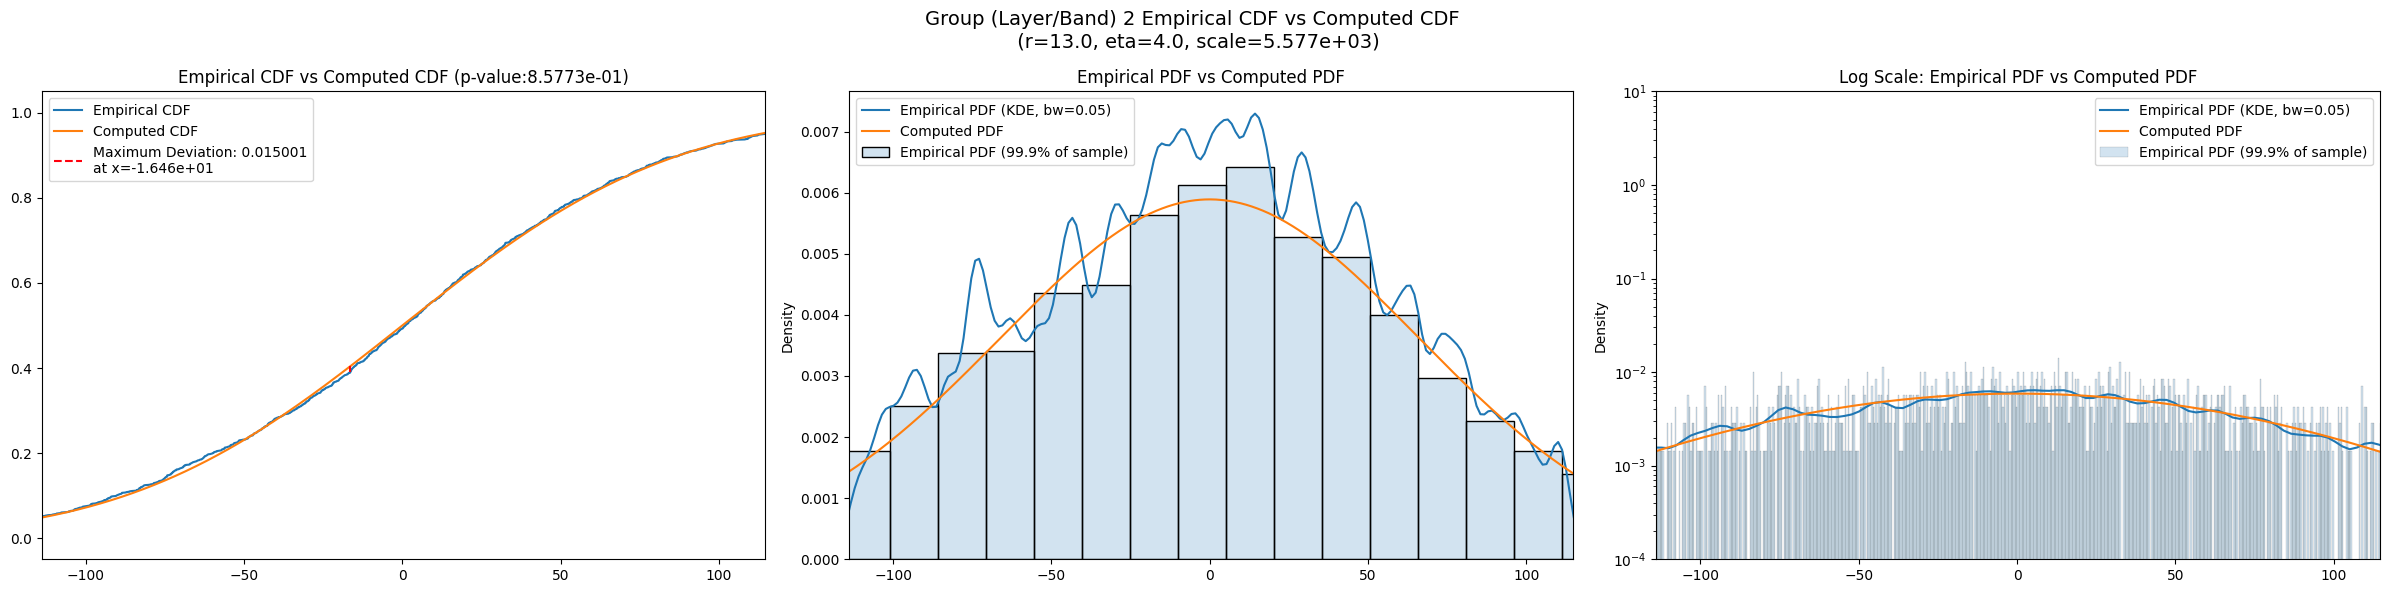

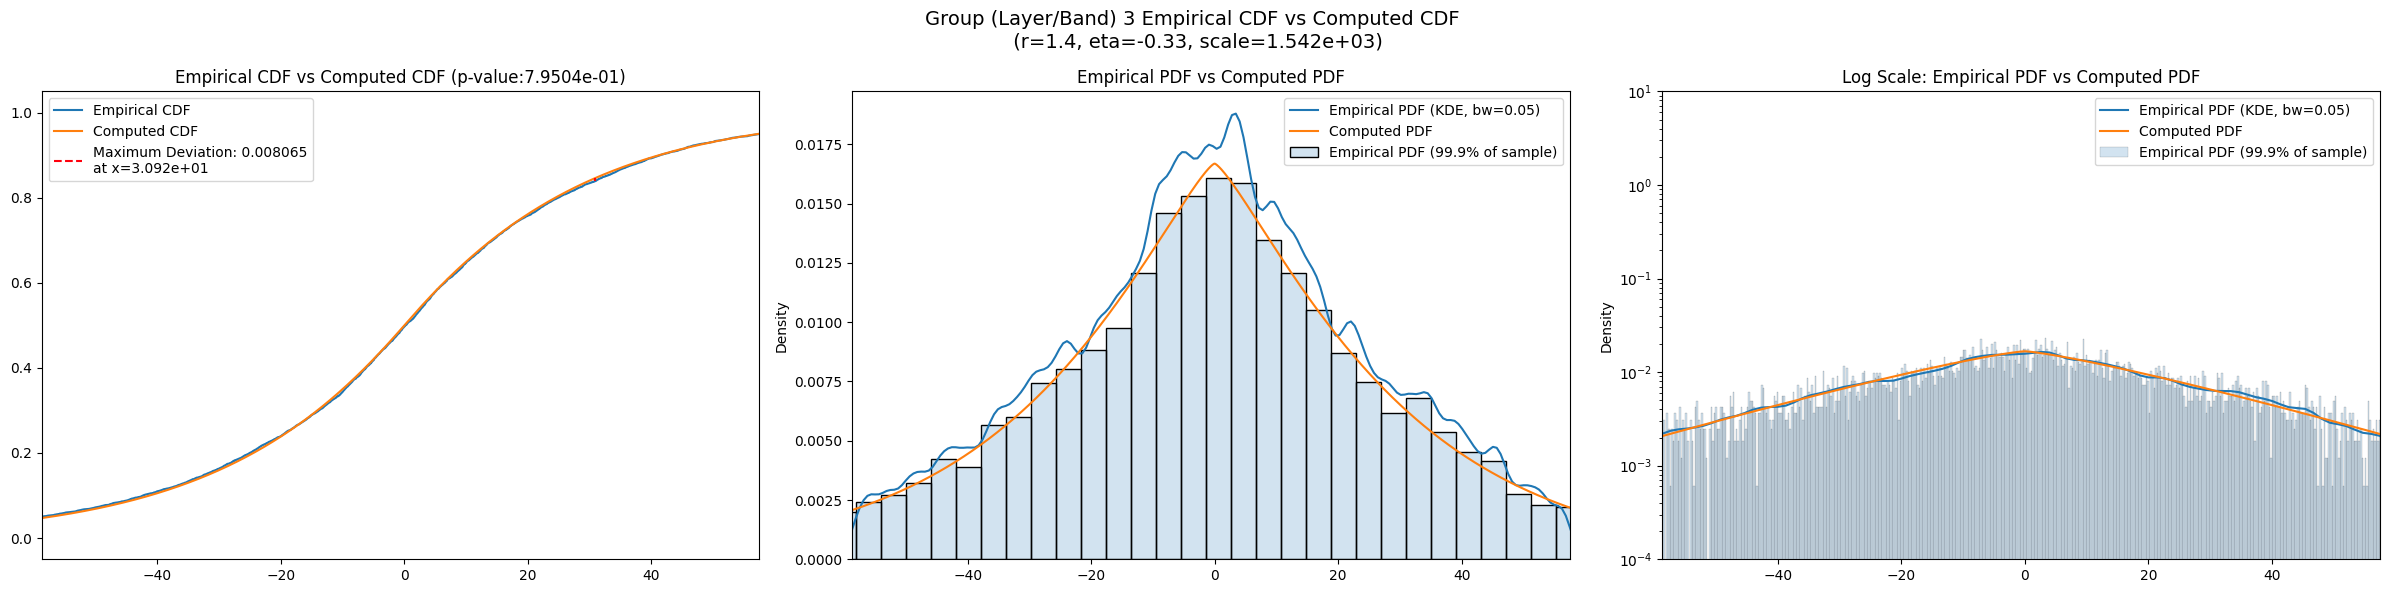

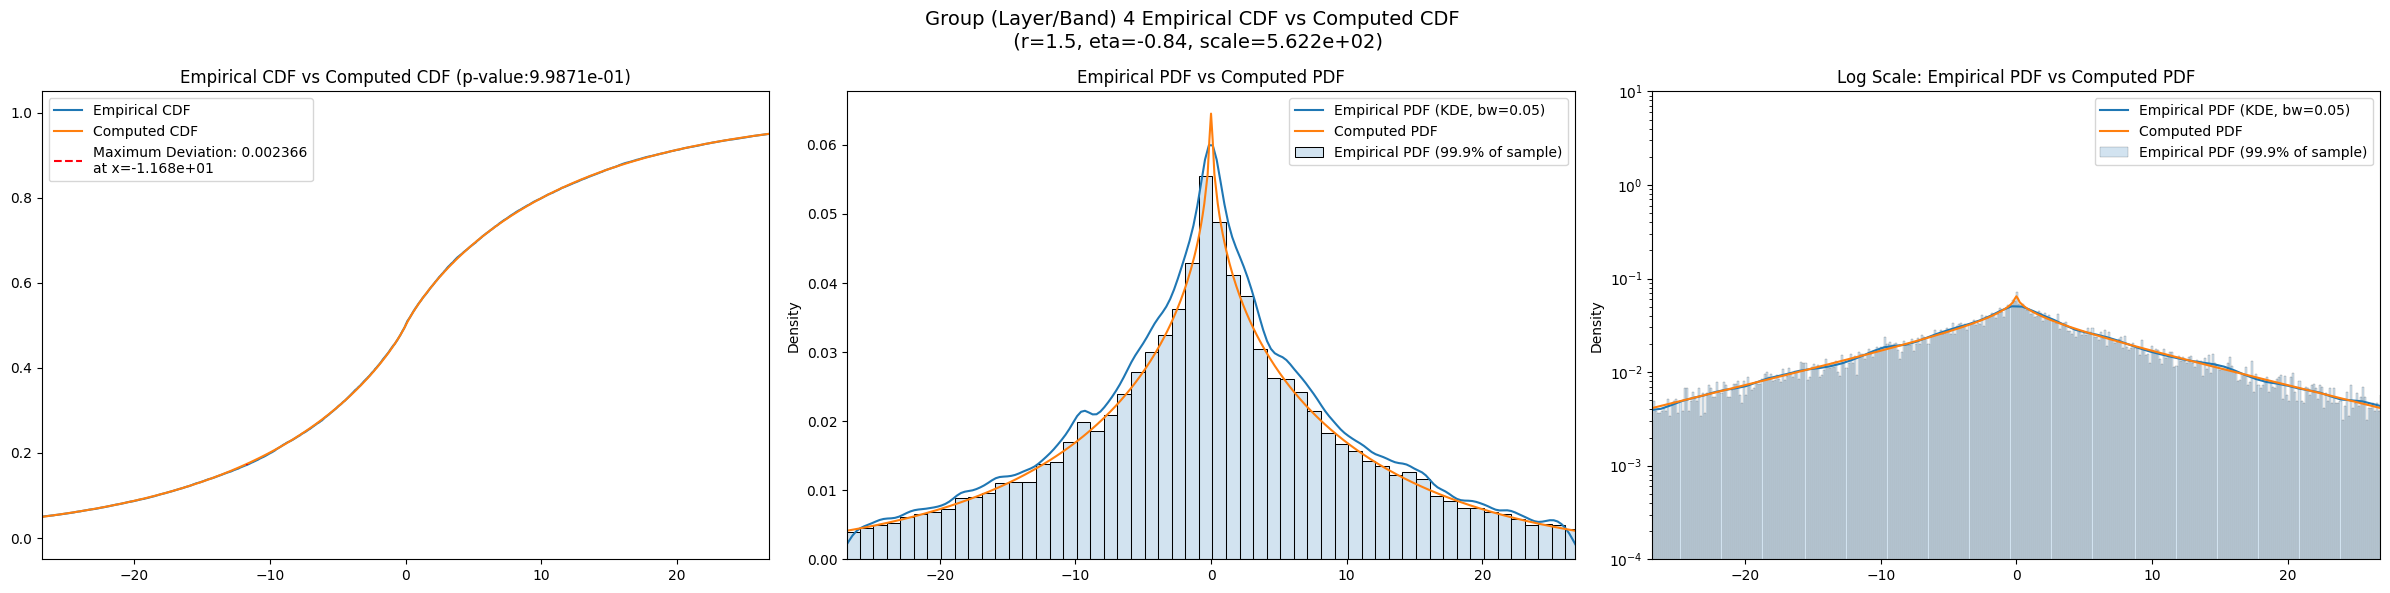

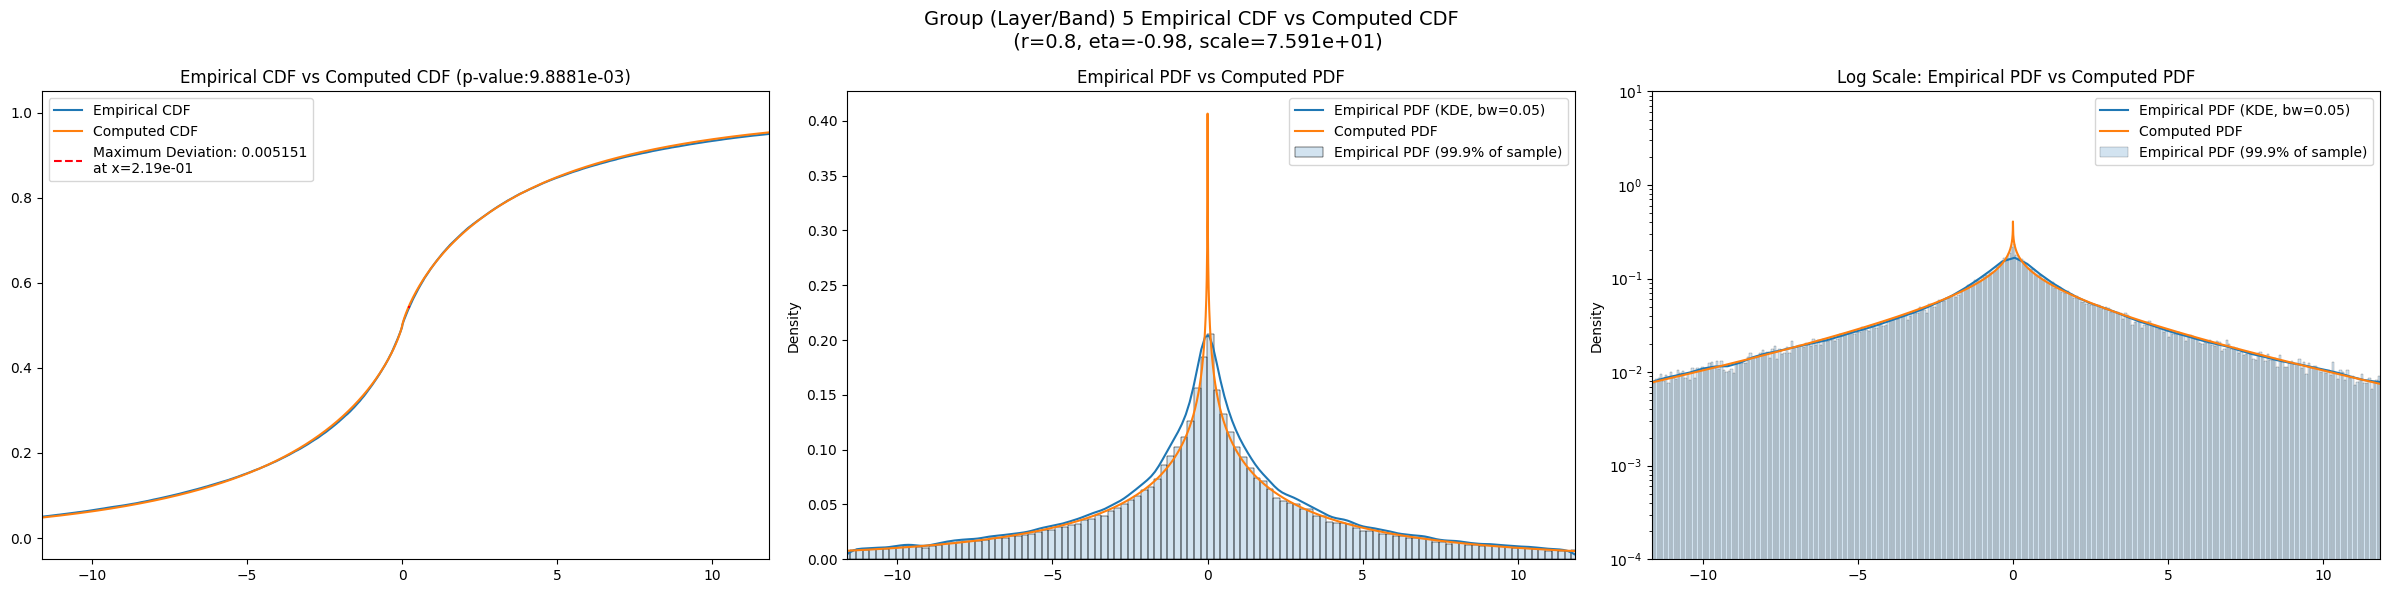

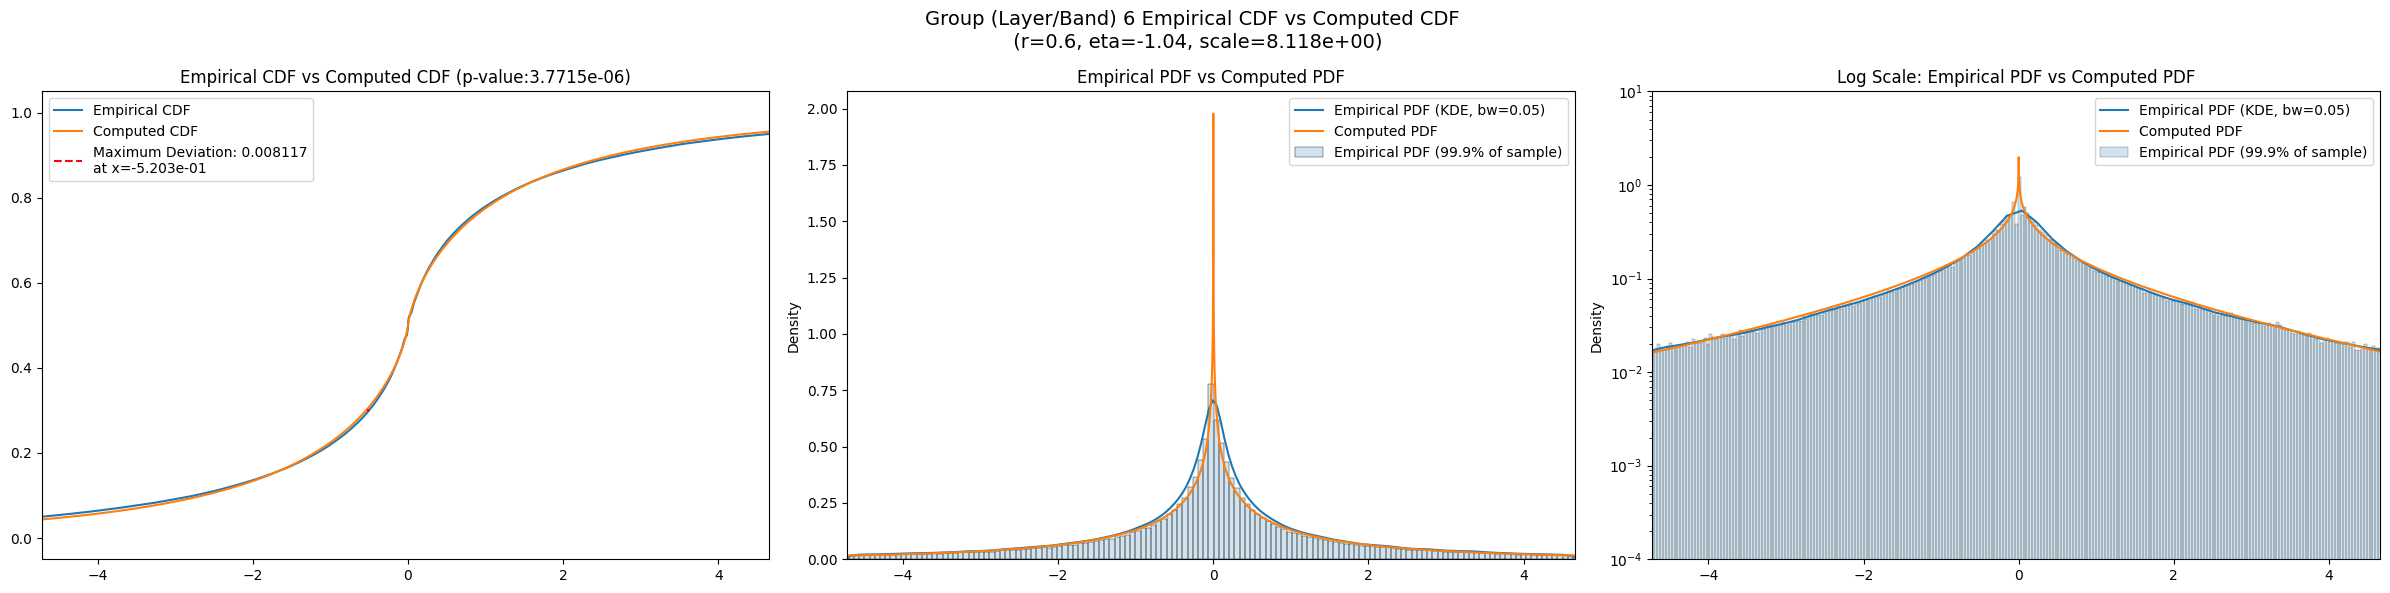

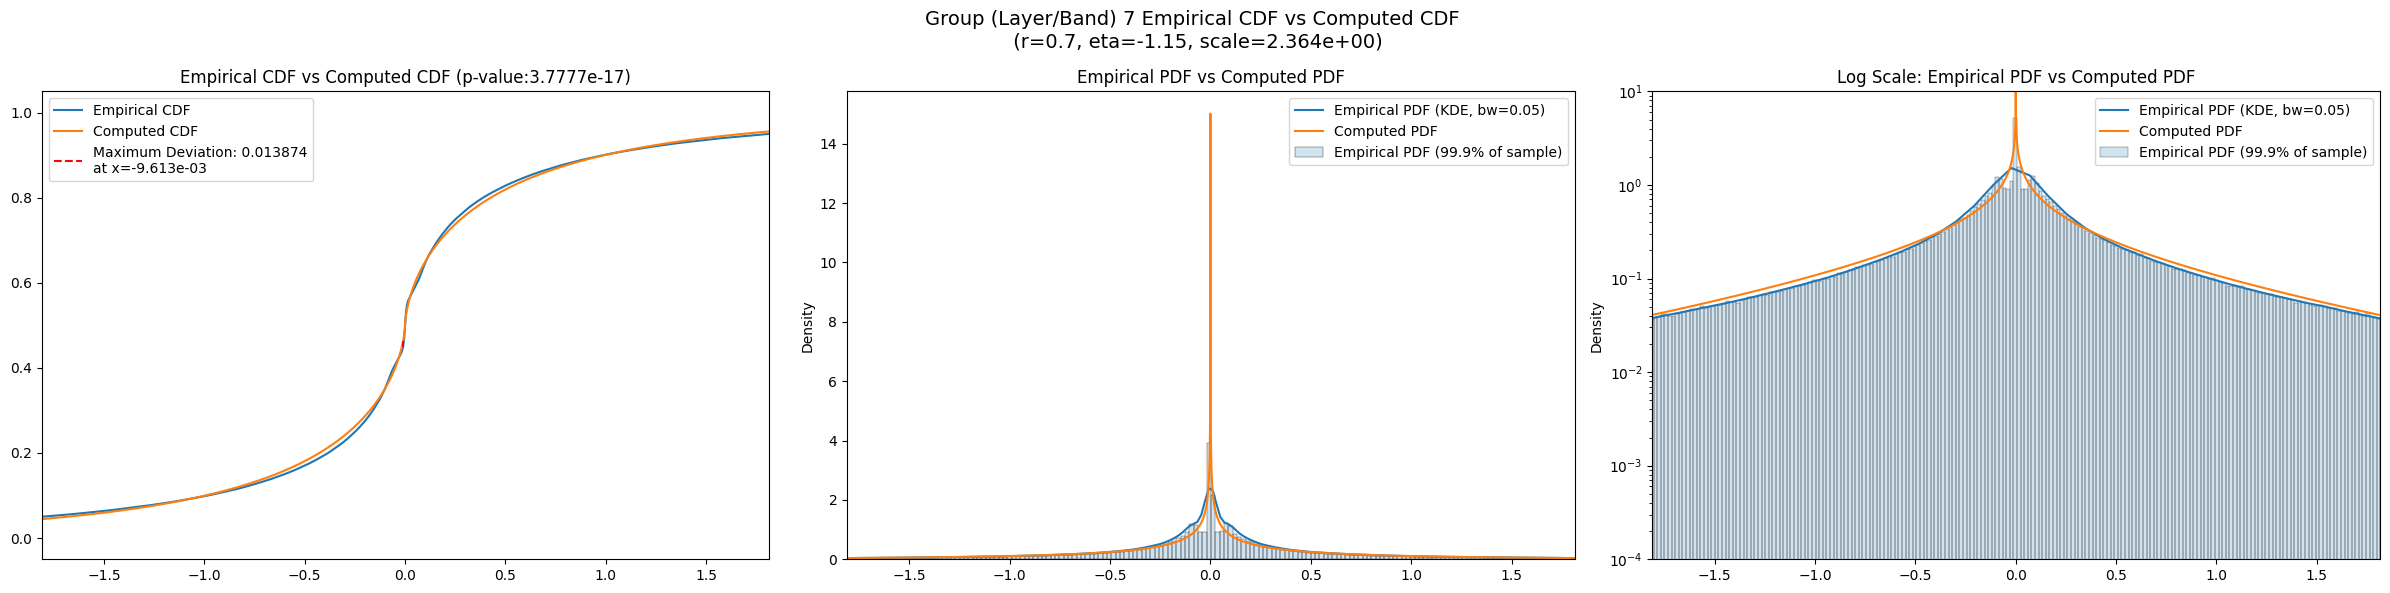

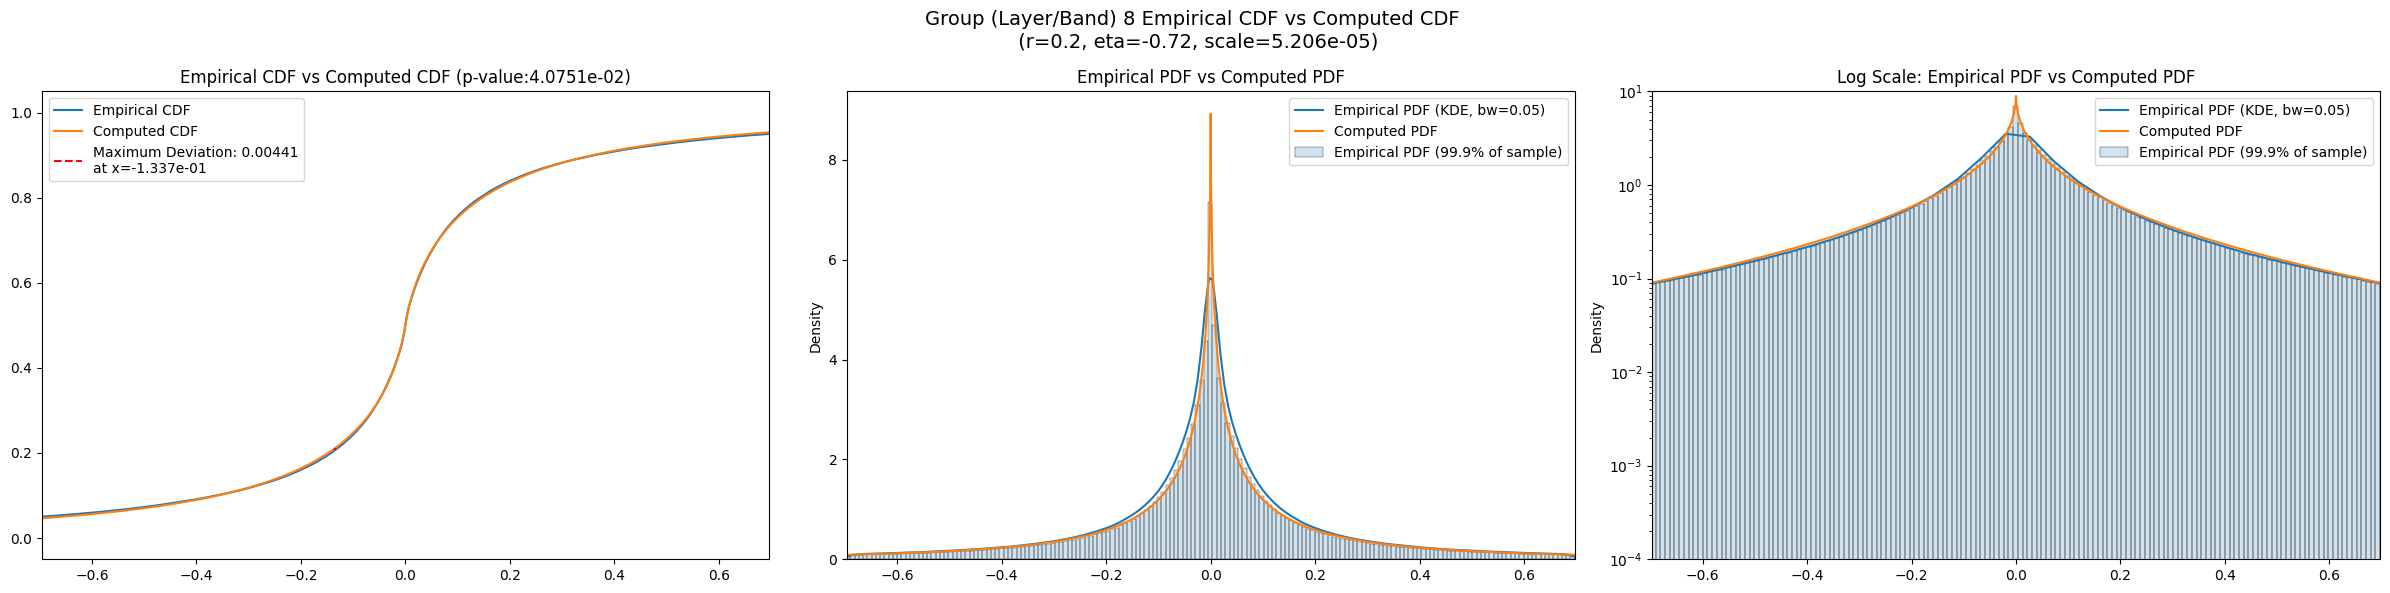

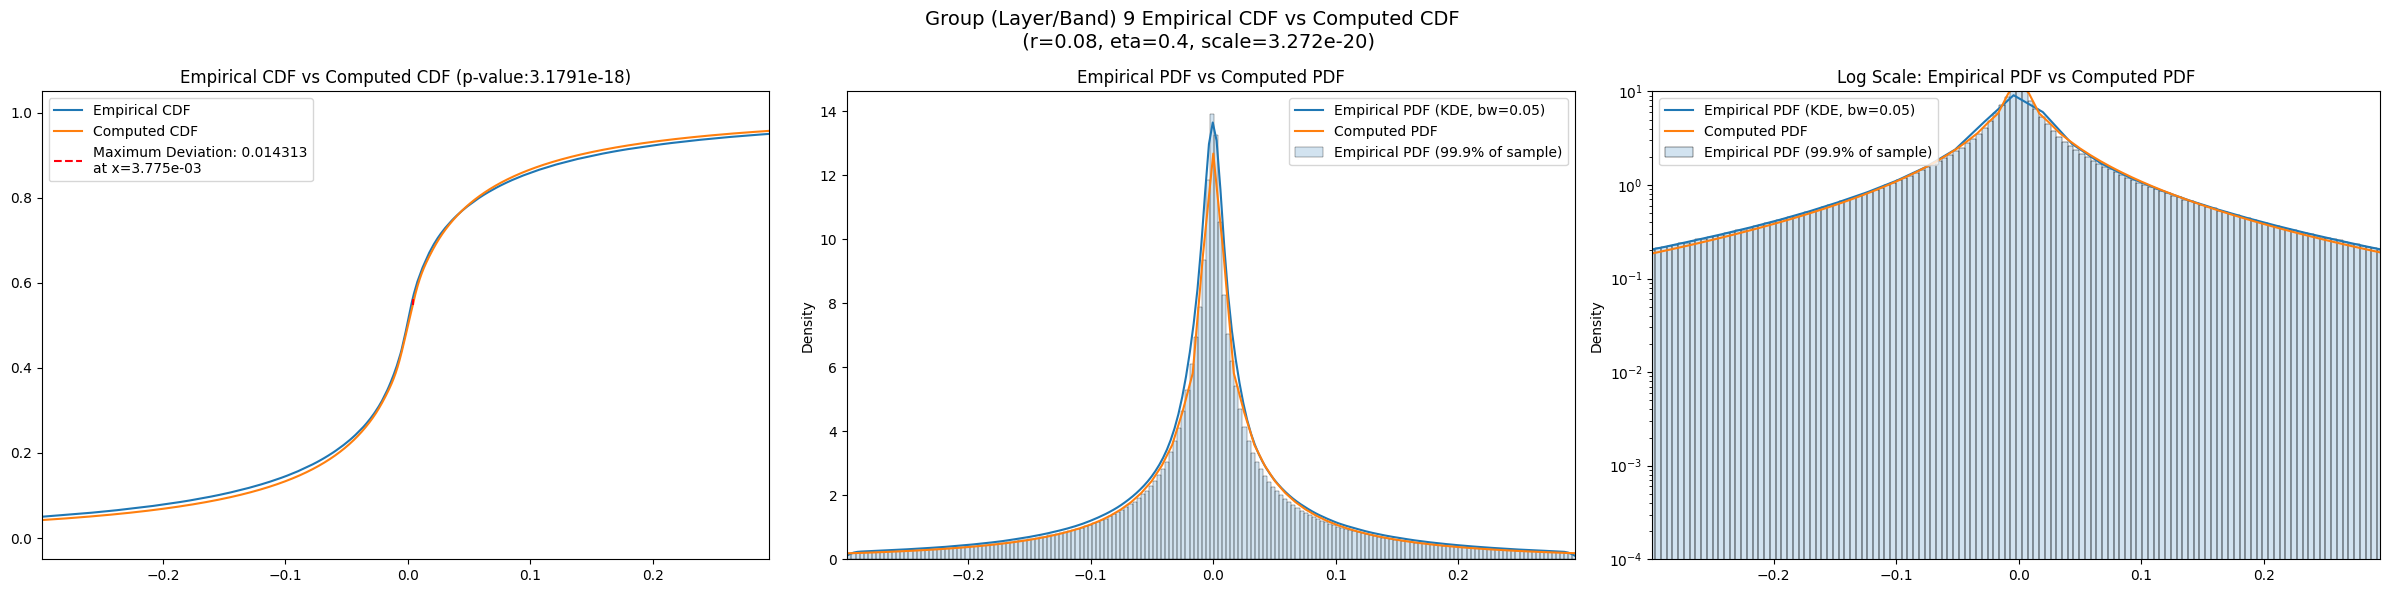

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      4718.657000  4299.349000  5150.550300  -0.054184   -0.312345   
3      1216.926300  1148.097900  1286.854100   1.147205    0.911357   
4       264.944550   250.008090   280.323400   2.901463    2.384805   
5        52.718760    49.047108    56.922474   6.263205    4.254791   
6         9.496005     8.706043    10.395535   9.788740    6.967327   
7         1.674932     1.508111     1.862111  14.589886   10.600601   
8         0.319952     0.279325     0.374371  29.505913   16.159815   
9         0.070265     0.059721     0.085715  46.324802   21.752464   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.254048           1604             0.015001       13.0          4.0   
3        1.392681           6416             0.008347        1.6         -0.4   
4        3.499158          25664             0.003264        1.3         -0.8   
5       16.023062         102656             0.005833        0.9         -1.0   
6       22.610666         410624             0.008604        0.5         -1.0   
7       28.399412        1642496             0.016122        0.5         -1.1   
8       97.240685        6569984             0.005785        0.2         -0.7   
9      167.660170       26279936             0.012399        0.1          0.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       68.029000              0.015368          8.373180e-01   
3      ...       29.953100              0.027030          1.662950e-04   
4      ...       12.334800              0.038209          5.437600e-33   
5      ...        4.450900              0.057244         7.754350e-293   
6      ...        1.490680              0.069805          0.000000e+00   
7      ...        0.505973              0.075879          0.000000e+00   
8      ...        0.192057              0.073089          0.000000e+00   
9      ...        0.075891              0.080687          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          59.584400             0.029622         1.174310e-01  48.322800   
3          27.011200             0.010707         4.506870e-01  21.783800   
4          10.733500             0.011043         3.794800e-03   8.910880   
5           3.873000             0.029808         1.130150e-79   3.105600   
6           1.290100             0.043726         0.000000e+00   1.012280   
7           0.441941             0.049745         0.000000e+00   0.344521   
8           0.169339             0.047351         0.000000e+00   0.130294   
9           0.066184             0.054878         0.000000e+00   0.051288   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.034883   3.939140e-02          8.577250e-01  
3           0.017716   3.521560e-02          7.950393e-01  
4           0.017187   5.143300e-07          9.987143e-01  
5           0.032440   2.724460e-94          8.588272e-03  
6           0.044883   0.000000e+00          6.339355e-24  
7           0.049273   0.000000e+00         4.888620e-275  
8           0.046048   0.000000e+00         1.962565e-111  
9           0.054797   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.015001                 0.033804          0.015001   
3                 0.008347                 0.016929          0.008065   
4                 0.003264                 0.008471          0.002366   
5                 0.005833                 0.004237          0.005151   
6                 0.008604                 0.002119          0.008117   
7                 0.016122                 0.001060          0.013874   
8                 0.005785                 0.000530          0.004410   
9                 0.012399                 0.000265          0.011995   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.015368             0.029622       0.034883  
3                  0.027030             0.010707       0.017716  
4                  0.038209             0.011043       0.017187  
5                  0.057244             0.029808       0.032440  
6                  0.069805             0.043726       0.044883  
7                  0.075879             0.049745       0.049273  
8                  0.073089             0.047351       0.046048  
9                  0.080687             0.054878       0.054797

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             4718.657000          0.015001   13.00      4.00  5.576727e+03   
3             1216.926270          0.008065    1.40     -0.33  1.542128e+03   
4              264.944550          0.002366    1.50     -0.84  5.622286e+02   
5               52.718761          0.005151    0.80     -0.98  7.590692e+01   
6                8.562589          0.008117    0.60     -1.04  8.117543e+00   
7                1.296453          0.013874    0.70     -1.15  2.364403e+00   
8                0.319952          0.004410    0.20     -0.72  5.205898e-05   
9                0.070265          0.011995    0.08      0.40  3.272356e-20   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    125.0  
7                    300.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()